In [2]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random
from functools import partial

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycox.datasets import kkbox_v1
from sklearn.model_selection import ParameterGrid
sys.path.append("../../")

from models import kkbox_main_network
from models_hard_mining import ContrastiveRankingModel
from batch_generators_hard_mining import DataGenerator
from tools import test_quality, preprocess_kkbox, transform_kkbox

In [3]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

Data

In [4]:
df_train = kkbox_v1.read_df(subset='train')
df_test = kkbox_v1.read_df(subset='test')
df_val = kkbox_v1.read_df(subset='val')

x_train, t_train, y_train = preprocess_kkbox(df_train)
x_val, t_val, y_val = preprocess_kkbox(df_val)
x_test, t_test, y_test = preprocess_kkbox(df_test)

x_train, x_test, x_val = transform_kkbox(x_train, x_test, x_val)
data = {
    'train': {
        'x': x_train,
        'y': y_train,
        't': t_train
    },
    'test': {
        'x': x_test,
        'y': y_test,
        't': t_test            
    },
    'val': {
        'x': x_val,
        'y': y_val,
        't': t_val            
        }
    }

In [9]:
model_params = {
    'inp_shape': (None, 40),
    'val_n_ex_bin': 1000,
    'n_ex_bin': 30,
    'n_epochs': 25,
    'seed': 5,
    'time_grid': np.linspace(1, np.max(data['val']['t']), 30, dtype=np.int),
    'alpha_bias_random_mean': 10.0,
    'alpha_random_stddev': 5.0,
    'beta_random_stddev': 5.0,
    'units_layers': [64, 32, 16],
    'dropout': 0,
    'alpha_reg': 1e-5
}
n_time_bins = [12, 15, 20]
contrastive_weight = [1e-10, 1e-2, 1e-1, 1, 5]
params = ParameterGrid({'contrastive_weight': contrastive_weight, 'n_time_bins': n_time_bins})

In [10]:
def get_loss(data, n_ex_bin, n_time_bins, sess, tensor_loss):
    dg = DataGenerator(x=data['x'], y=data['y'], t=data['t'], n_ex_bin=n_ex_bin, n_time_bins=n_time_bins)
    gen = dg.get_batch()
    l = 0
    while True:
        try:    
            x_batch, y_batch, target = next(gen)
            l =+ sess.run(tensor_loss, feed_dict={
                "x:0": x_batch,
                "t:0": y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                "y:0": y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                "target:0": target.reshape((y_batch[:, 0].shape[0], 1))
            })   
        except StopIteration:
            return l
        
def test_model(train_data, test_data, model_params):
    kkbox_main_network_current = partial(kkbox_main_network, units_in_layers=model_params['units_layers'], dropout=model_params['dropout'])
    model = ContrastiveRankingModel(
        input_shape=model_params['inp_shape'], seed=model_params['seed'],
        main_network=kkbox_main_network_current, alpha_reg=model_params['alpha_reg'],
        alpha_bias_random_mean=model_params['alpha_bias_random_mean'], 
        alpha_random_stddev=model_params['alpha_random_stddev'], 
        beta_random_stddev=model_params['beta_random_stddev'],
        contrastive_weight=model_params['contrastive_weight'])
    
    step_rate = 10
    decay = 0.9
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = tf.train.exponential_decay(0.001, global_step, step_rate, decay, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(model.loss)
    
    # train data
    dg = DataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], n_ex_bin=model_params['n_ex_bin'], 
                                  n_time_bins=model_params['n_time_bins'])
    all_lr = []
    hist_losses_train = []
    hist_losses_val = []
    all_pred_train = []
    all_pred_val = []
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                while True:
                    try:
                        # get batch data
                        x_batch, y_batch, target = next(gen)
                        feed_dict = {
                            model.x: x_batch,
                            model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                            model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                            model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                        }
                        # train model
                        _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    except StopIteration:
                        break
                # prediction at val
                pred = sess.run(model.o1, feed_dict={model.x: test_data['x']})
                all_pred_val.append(pred)
                l = get_loss(data=test_data, n_ex_bin=model_params['val_n_ex_bin'], n_time_bins=model_params['n_time_bins'], sess=sess, tensor_loss=model.loss)
                hist_losses_val.append(l)   
                print(l)
                pred = sess.run(model.o1, feed_dict={model.x: train_data['x']})
                all_pred_train.append(pred)
                l = get_loss(data=train_data, n_ex_bin=model_params['val_n_ex_bin'], n_time_bins=model_params['n_time_bins'], sess=sess, tensor_loss=model.loss)
                hist_losses_train.append(l) 

    return hist_losses_train, hist_losses_val, all_pred_train, all_pred_val


In [ ]:
every_nth_epoch = 3

all_res_quality = []

train_data = data['train']
test_data = data['test']

for par in tqdm(params):
    tf.reset_default_graph()
    par.update(model_params)
    print(par)
    train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=par)
    pred_to_estimate = pred_val[::every_nth_epoch]
    all_q = []
    for idx, pred in enumerate(pred_to_estimate):
        q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=model_params['time_grid'], concordance_at_t=None, plot=False)
        q['epoch'] = every_nth_epoch * idx
        all_q.append(q)
    q = pd.concat(all_q)
    q.reset_index(drop=True, inplace=True)
    q['test_loss'] = ''
    q['train_loss'] = ''
    q.at[0, 'test_loss'] = val_loss
    q.at[0, 'train_loss'] = train_loss
    q['cross_entropy_weight'] = par['cross_entropy_weight']
    all_res_quality.append(q)
    print(all_res_quality)
    with open('../../output/kkbox_weibull_contr_alpha_sgd.pkl', 'wb') as f:
        pickle.dump(all_res_quality, f)

{'contrastive_weight': 1e-10, 'n_time_bins': 12, 'inp_shape': (None, 40), 'val_n_ex_bin': 1000, 'n_ex_bin': 30, 'n_epochs': 25, 'seed': 5, 'time_grid': array([  1,  29,  57,  85, 113, 142, 170, 198, 226, 255, 283, 311, 339,
       368, 396, 424, 452, 481, 509, 537, 565, 594, 622, 650, 678, 707,
       735, 763, 791, 820]), 'alpha_bias_random_mean': 10.0, 'alpha_random_stddev': 5.0, 'beta_random_stddev': 5.0, 'units_layers': [64, 32, 16], 'dropout': 0, 'alpha_reg': 1e-05}


1.4111725
1.402732
1.3976276
1.3814884
1.3774778
1.3835905
1.373865
1.3785467
1.3633544
1.375698
1.3778483
1.3733262
1.3745624
1.3621842
1.370809
1.3826095
1.3676715
1.3773367
1.3641763
1.3761225
1.3698412
1.3722335
1.3713453
1.3687447
1.370151



In [8]:
every_nth_epoch = 3

all_res_quality = []

train_data = data['train']
test_data = data['test']

for par in tqdm(params):
    tf.reset_default_graph()
    par.update(model_params)
    train_loss, val_loss, pred_train, pred_val = test_model(train_data=train_data, test_data=test_data, model_params=par)
    pred_to_estimate = pred_val[::every_nth_epoch]
    all_q = []
    for idx, pred in enumerate(pred_to_estimate):
        q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=model_params['time_grid'], concordance_at_t=None, plot=False)
        q['epoch'] = every_nth_epoch * idx
        all_q.append(q)
    q = pd.concat(all_q)
    q.reset_index(drop=True, inplace=True)
    q['test_loss'] = ''
    q['train_loss'] = ''
    q.at[0, 'test_loss'] = val_loss
    q.at[0, 'train_loss'] = train_loss
    q['cross_entropy_weight'] = par['cross_entropy_weight']
    all_res_quality.append(q)
    print(all_res_quality)
    with open('../../output/kkbox_weibull_contr_alpha_sgd_0.pkl', 'wb') as f:
        pickle.dump(all_res_quality, f)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


5.368538
5.430868
5.4175406
5.34355
5.3296957
5.353485
5.335909
5.3787127
5.3592186
5.347616
5.3806105
5.3380075
5.3967094
5.310052
5.3703413
5.3337736
5.332905
5.3843794
5.3176217
5.343749
5.3865094
5.3217444
5.3314
5.3413477
5.3290744

[   dt_c_index  int_brier_score  int_nbill  epoch  \
0    0.834752         0.129037   0.399220      0   
1    0.845278         0.125625   0.389279      3   
2    0.847122         0.124806   0.386227      6   
3    0.847297         0.126753   0.389726      9   
4    0.850522         0.122397   0.379894     12   
5    0.851204         0.121674   0.377941     15   
6    0.851875         0.120778   0.375774     18   
7    0.852642         0.119371   0.373153     21   
8    0.852212         0.121620   0.377312     24   

                                           test_loss  \
0  [5.368538, 5.430868, 5.4175406, 5.34355, 5.329...   
1                                                      
2                                                      
3               

6.352256
6.4306617
6.413157
6.332002
6.317241
6.3455706
6.320625
6.3748903
6.3535957
6.3412166
6.3788447
6.308076
6.401321
6.2942486
6.366109
6.320188
6.3212295
6.3896775
6.3064027
6.3294883
6.393501
6.3077745
6.315518
6.3420734
6.3175545

[   dt_c_index  int_brier_score  int_nbill  epoch  \
0    0.834752         0.129037   0.399220      0   
1    0.845278         0.125625   0.389279      3   
2    0.847122         0.124806   0.386227      6   
3    0.847297         0.126753   0.389726      9   
4    0.850522         0.122397   0.379894     12   
5    0.851204         0.121674   0.377941     15   
6    0.851875         0.120778   0.375774     18   
7    0.852642         0.119371   0.373153     21   
8    0.852212         0.121620   0.377312     24   

                                           test_loss  \
0  [5.368538, 5.430868, 5.4175406, 5.34355, 5.329...   
1                                                      
2                                                      
3             

In [9]:
import seaborn as sns

In [10]:
with open('../../output/kkbox_weibull_ce_alpha_sgd.pkl', 'rb') as f:
    df = pickle.load(f)
with open('../../output/kkbox_weibull_ce_alpha_sgd_0.pkl', 'rb') as f:
    df.extend(pickle.load(f))

In [11]:
df = pd.concat(df)

In [12]:
df.head()

,dt_c_index,int_brier_score,int_nbill,epoch,test_loss,train_loss,cross_entropy_weight
0,0.833913,0.125948,0.389186,0,"[1.4211478, 1.4127456, 1.4076855, 1.3914324, 1...","[1.4151206, 1.3993776, 1.404609, 1.3993081, 1....",0.01
1,0.843969,0.120411,0.374344,3,,,0.01
2,0.846925,0.118831,0.369429,6,,,0.01
3,0.848830,0.117892,0.366366,9,,,0.01
4,0.850020,0.117248,0.364994,12,,,0.01


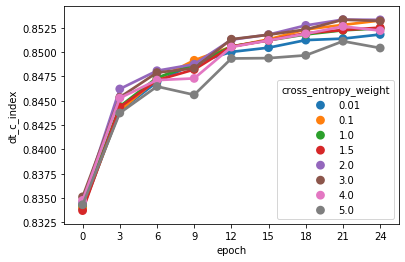

In [13]:
sns.pointplot(x=df['epoch'], y=df['dt_c_index'], hue=df['cross_entropy_weight'])

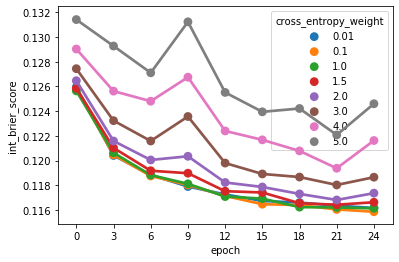

In [14]:
sns.pointplot(x=df['epoch'], y=df['int_brier_score'], hue=df['cross_entropy_weight'])

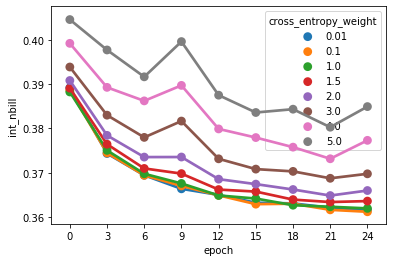

In [15]:
sns.pointplot(x=df['epoch'], y=df['int_nbill'],hue=df['cross_entropy_weight'])